**Ejercicio 1:** Implemente el algoritmo de entrenamiento de un SOM bidimensional de forma que se pueda ver gráficamente el mapa topológico durante todo el proceso. Para poder observar el ordenamiento topológico, en el mapa grafique líneas de unión entre pares de neuronas vecinas. Realice las pruebas de ordenamiento topológico con los patrones provistos en los archivos circulo.csv y te.csv, usando un máximo de 1000 épocas de entrenamiento.

#### <b>Librerías</b>

In [6]:
import random
import csv
import numpy as np
import time
import copy
import matplotlib.pyplot as plt

#### **Inicialización**

Determinamos la estructura de nuestro SOM, determinando *filas* y *columnas* de una matriz para el caso bidimensional (para este caso, hacemos 15x15 como mucho para simplificar). Si queremos un SOM unidimensional, seteamos *filas* = 1 y las *columnas* de la dimensión deseada.

Además, definimos el radio de vecindad a tener en cuenta con la variable *rv*. Por ejemplo: si *rv* = 1, entonces actualizamos los pesos de la neurona ganadora y de aquellas que entran en un rombo de radio 1. 

In [7]:
filas = 10                       # Filas de neuronas
columnas = 10                    # Columnas de neuronas
v_rv = [5,2,0]                   # Radio de vecindad por etapa
v_epoca_max = [1000,1000,3000]   # Épocas máximas por etapa
v_mu = [0.8, 0.1, 0.02]          # Velocidad de aprendizaje por etapa
tol = 1e-8                       # Tolerancia de error para indicar convergencia

Levantamos los datos del archivo .csv e inicializamos al azar los pesos para todas las neuronas del SOM. Así, obtenemos una matriz de vectores de pesos tal que los índices [i,j] de la matriz me van a dar el índice para cada neurona dentro de mi arreglo bidimensional y me manejo con eso para las vecindades.

Otra alternativa para la inicialización de los pesos podría ser escoger al azar una entrada para cada neurona y asignarla como peso.

In [8]:
# Entradas desde el archivo .csv:
inputs = np.loadtxt('./data/circulo.csv',delimiter=',')
cant_e = len(inputs[0])

# Inicializo al azar los pesos:
W = np.empty([filas,columnas], dtype=object)
for i in range(filas):
    for j in range(columnas):
        W[i,j] = np.random.rand(cant_e)-0.5

print(W)    # Visualizo estructura de la matriz de vectores de peso.

[[array([0.27212878, 0.36166478]) array([-0.11350576,  0.30166163])
  array([ 0.06879712, -0.31752185]) array([-0.09616538, -0.10894797])
  array([-0.34606147,  0.39398443]) array([0.2394939 , 0.01599391])
  array([0.31012294, 0.2828466 ]) array([-0.26421154,  0.02169502])
  array([-0.45811002,  0.48998144]) array([-0.11420883,  0.29942052])]
 [array([-0.18104837,  0.37106809]) array([ 0.00830696, -0.08158389])
  array([-0.28706559,  0.16927999]) array([0.11358822, 0.07864194])
  array([ 0.00238083, -0.0710988 ]) array([-0.31322052,  0.20635222])
  array([-0.12926281, -0.44302284]) array([ 0.38087321, -0.11734111])
  array([-0.49132258, -0.3752266 ]) array([-0.09991117,  0.020838  ])]
 [array([-0.04601927, -0.02400553]) array([-0.01602348,  0.11998669])
  array([0.27304419, 0.06690138]) array([ 0.32309142, -0.46390683])
  array([-0.33589365, -0.27873282]) array([-0.4037855 ,  0.20158396])
  array([0.40628202, 0.13669855]) array([ 0.4727312 , -0.16703571])
  array([0.27728307, 0.2197441

#### **Entrenamiento**

Para este caso, a modo de simplificación, los pesos serán actualizados teniendo en cuenta una distancia cuadrada (actualización es la misma para neurona ganadora y sus vecinas, en vez de usar una gaussiana o similares que actualizan en menor medida los pesos según la distancia a la ganadora).

In [9]:
for etapa in range(3): # tres etapas: ordenamiento global, transición y ajuste fino (convergencia)
    rv = v_rv[etapa]
    mu = v_mu[etapa]
    epoca = 0
    W_saved = [copy.deepcopy(W)]
    inicio=time.time()

    while epoca < v_epoca_max[etapa]:

        for input in inputs:
            # Obtengo neurona ganadora buscando peso de menor distancia en W:
            dist = [[np.linalg.norm(input - w) for w in row] for row in W]
            indice = np.unravel_index(np.argmin(dist),W.shape)

            # ACTUALIZACIONES
            error = input - W[indice]
            inc = mu*error
            
            # Me tengo que fijar que no se me vaya a índices negativos o fuera de los límites de la matriz
            for k in range(0,rv+1):                 # Empieza en 0 para hacer la fila de la neurona ganadora      
                d = indice[0] + k                   # Me desplazo una fila abajo
                if (d < filas):
                    W[d,indice[1]] += inc
                    for j in range(1,rv+1-k):       # En esa fila, voy a la izquierda
                        dL = indice[1] - j
                        if(dL > -1): W[d,dL] += inc
                        else: break
                    for j in range(1,rv+1-k):       # En esa fila, voy a la derecha
                        dR = indice[1] + j
                        if(dR < columnas): W[d,dR] += inc
                        else: break
                else: break
            
            for k in range(1,rv+1):               # Empieza en 1 porque ya hice la fila de la neurona ganadora antes
                d = indice[0] - k                 # Me desplazo una fila arriba
                if (d > -1):
                    W[d,indice[1]] += inc
                    for j in range(1,rv+1-k):       # En esa fila, voy a la izquierda
                        dL = indice[1] - j
                        if(dL > -1): W[d,dL] += inc
                        else: break
                    for j in range(1,rv+1-k):       # En esa fila, voy a la derecha
                        dR = indice[1] + j
                        if(dR < columnas): W[d,dR] += inc
                        else: break
                else: break
    
        flag = False
        for i in range(filas):
            for j in range(columnas):
                W_last = W_saved[-1]
                if not np.all(np.abs(W_last[i,j] - W[i,j]) < tol):
                    flag = True  # Si hay alguna diferencia mayor que la tolerancia, pongo bandera en true y continúo con las épocas
        if flag == False:
            break

        W_saved.append(copy.deepcopy(W))
        epoca += 1

    fin = time.time()
    duracion = fin - inicio 
    print('La etapa',etapa+1,'finalizó en la época',epoca,'en',round(duracion,2),'segundos.')


La etapa 1 finalizó en la época 1000 en 203.76 segundos.
La etapa 2 finalizó en la época 1000 en 191.65 segundos.
La etapa 3 finalizó en la época 5 en 1.09 segundos.


#### **Gráfica**

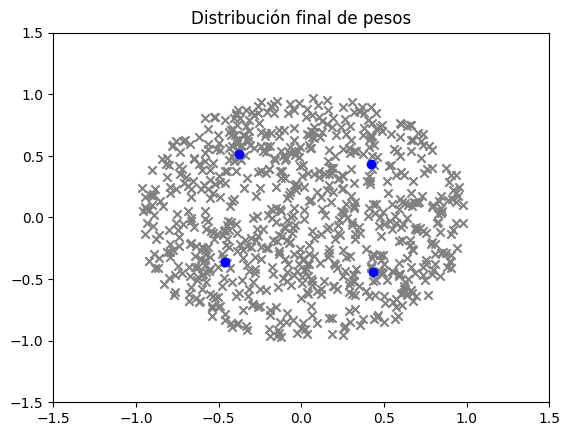

In [10]:
fig,ax = plt.subplots()

ax.set(xlim=[-1.5,1.5],ylim=[-1.5,1.5],title='Distribución final de pesos')
ax.scatter(inputs[:,0], inputs[:,1], marker='x', color='grey')  # Patrones de entrada

# Neuronas
x = np.array([[W[i, j][0] for j in range(columnas)] for i in range(filas)])
y = np.array([[W[i, j][1] for j in range(columnas)] for i in range(filas)])

ax.scatter(x.ravel(),y.ravel(),marker='o',color='blue')
plt.show()